In [1]:
# default_exp models.nbeats.nbeats

In [2]:
#hide
%load_ext autoreload
%autoreload 2

In [3]:
#export
import os
import time
import numpy as np
import pandas as pd
import random
from collections import defaultdict
import copy

import torch as t
from torch import optim
from pathlib import Path
from functools import partial

from nixtla.models.nbeats.nbeats_model import NBeats, NBeatsBlock, IdentityBasis, TrendBasis, SeasonalityBasis
from nixtla.models.nbeats.nbeats_model import ExogenousBasisInterpretable, ExogenousBasisWavenet, ExogenousBasisTCN
from nixtla.losses.pytorch import MAPELoss, MASELoss, SMAPELoss, MSELoss, MAELoss, PinballLoss
from nixtla.losses.numpy import mae, mse, mape, smape, rmse, pinball_loss


In [4]:
#export
def init_weights(module, initialization):
    if type(module) == t.nn.Linear:
        if initialization == 'orthogonal':
            t.nn.init.orthogonal_(module.weight)
        elif initialization == 'he_uniform':
            t.nn.init.kaiming_uniform_(module.weight)
        elif initialization == 'he_normal':
            t.nn.init.kaiming_normal_(module.weight)
        elif initialization == 'glorot_uniform':
            t.nn.init.xavier_uniform_(module.weight)
        elif initialization == 'glorot_normal':
            t.nn.init.xavier_normal_(module.weight)
        elif initialization == 'lecun_normal':
            pass #t.nn.init.normal_(module.weight, 0.0, std=1/np.sqrt(module.weight.numel()))
        else:
            assert 1<0, f'Initialization {initialization} not found'

class Nbeats(object):
    """
    Future documentation
    """
    SEASONALITY_BLOCK = 'seasonality'
    TREND_BLOCK = 'trend'
    IDENTITY_BLOCK = 'identity'

    def __init__(self,
                 input_size_multiplier,
                 output_size,
                 shared_weights,
                 activation,
                 initialization,
                 stack_types,
                 n_blocks,
                 n_layers,
                 n_hidden,
                 n_harmonics,
                 n_polynomials,
                 exogenous_n_channels,
                 include_var_dict,
                 t_cols,
                 batch_normalization,
                 dropout_prob_theta,
                 dropout_prob_exogenous,
                 x_s_n_hidden,
                 learning_rate,
                 lr_decay,
                 n_lr_decay_steps,
                 weight_decay,
                 l1_theta,
                 n_iterations,
                 early_stopping,
                 loss,
                 loss_hypar,
                 frequency,
                 random_seed,
                 seasonality,
                 device=None):
        super(Nbeats, self).__init__()

        if activation == 'selu': initialization = 'lecun_normal'

        #------------------------ Model Attributes ------------------------#
        # Architecture parameters
        self.input_size = int(input_size_multiplier*output_size)
        self.output_size = output_size
        self.shared_weights = shared_weights
        self.activation = activation
        self.initialization = initialization
        self.stack_types = stack_types
        self.n_blocks = n_blocks
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_harmonics = n_harmonics
        self.n_polynomials = n_polynomials
        self.exogenous_n_channels = exogenous_n_channels
        self.include_var_dict = include_var_dict
        self.t_cols = t_cols

        # Regularization and optimization parameters
        self.batch_normalization = batch_normalization
        self.dropout_prob_theta = dropout_prob_theta
        self.dropout_prob_exogenous = dropout_prob_exogenous
        self.x_s_n_hidden = x_s_n_hidden
        self.learning_rate = learning_rate
        self.lr_decay = lr_decay
        self.n_lr_decay_steps = n_lr_decay_steps
        self.weight_decay = weight_decay
        self.n_iterations = n_iterations
        self.early_stopping = early_stopping
        self.loss = loss
        self.loss_hypar = loss_hypar
        self.l1_theta = l1_theta
        self.l1_conv = 1e-3 # Not a hyperparameter        

        # Regularization and optimization parameters
        self.frequency = frequency
        self.seasonality = seasonality
        self.random_seed = random_seed

        if device is None:
            device = 'cuda' if t.cuda.is_available() else 'cpu'
        self.device = device

        self._is_instantiated = False

    def create_stack(self):
        if self.include_var_dict is not None:
            x_t_n_inputs = self.output_size * int(sum([len(x) for x in self.include_var_dict.values()]))
            
            # Correction because week_day only adds 1 no output_size
            if len(self.include_var_dict['week_day'])>0:
                x_t_n_inputs = x_t_n_inputs - self.output_size + 1 
        else:
            x_t_n_inputs = self.input_size
        
        #------------------------ Model Definition ------------------------#
        block_list = []
        self.blocks_regularizer = []
        for i in range(len(self.stack_types)):
            #print(f'| --  Stack {self.stack_types[i]} (#{i})')
            for block_id in range(self.n_blocks[i]):
                
                # Batch norm only on first block
                if (len(block_list)==0) and (self.batch_normalization):
                    batch_normalization_block = True
                else:
                    batch_normalization_block = False
                
                # Dummy of regularizer in block. Override with 1 if exogenous_block
                self.blocks_regularizer += [0]

                # Shared weights
                if self.shared_weights and block_id>0:
                    nbeats_block = block_list[-1]
                else:
                    if self.stack_types[i] == 'seasonality':
                        nbeats_block = NBeatsBlock(x_t_n_inputs = x_t_n_inputs,
                                                   x_s_n_inputs = self.n_x_s,
                                                   x_s_n_hidden= self.x_s_n_hidden,
                                                   theta_n_dim=4 * int(
                                                        np.ceil(self.n_harmonics / 2 * self.output_size) - (self.n_harmonics - 1)),
                                                   basis=SeasonalityBasis(harmonics=self.n_harmonics,
                                                                          backcast_size=self.input_size,
                                                                          forecast_size=self.output_size),
                                                   n_layers=self.n_layers[i],
                                                   theta_n_hidden=self.n_hidden[i],
                                                   include_var_dict=self.include_var_dict,
                                                   t_cols=self.t_cols,
                                                   batch_normalization=batch_normalization_block,
                                                   dropout_prob=self.dropout_prob_theta,
                                                   activation=self.activation)
                    elif self.stack_types[i] == 'trend':
                        nbeats_block = NBeatsBlock(x_t_n_inputs = x_t_n_inputs,
                                                   x_s_n_inputs = self.n_x_s,
                                                   x_s_n_hidden= self.x_s_n_hidden,
                                                   theta_n_dim=2 * (self.n_polynomials + 1),
                                                   basis=TrendBasis(degree_of_polynomial=self.n_polynomials,
                                                                            backcast_size=self.input_size,
                                                                            forecast_size=self.output_size),
                                                   n_layers=self.n_layers[i],
                                                   theta_n_hidden=self.n_hidden[i],
                                                   include_var_dict=self.include_var_dict,
                                                   t_cols=self.t_cols,
                                                   batch_normalization=batch_normalization_block,
                                                   dropout_prob=self.dropout_prob_theta,
                                                   activation=self.activation)
                    elif self.stack_types[i] == 'identity':
                        nbeats_block = NBeatsBlock(x_t_n_inputs = x_t_n_inputs,
                                                   x_s_n_inputs = self.n_x_s,
                                                   x_s_n_hidden= self.x_s_n_hidden,
                                                   theta_n_dim=self.input_size + self.output_size,
                                                   basis=IdentityBasis(backcast_size=self.input_size,
                                                                       forecast_size=self.output_size),
                                                   n_layers=self.n_layers[i],
                                                   theta_n_hidden=self.n_hidden[i],
                                                   include_var_dict=self.include_var_dict,
                                                   t_cols=self.t_cols,
                                                   batch_normalization=batch_normalization_block,
                                                   dropout_prob=self.dropout_prob_theta,
                                                   activation=self.activation)
                    elif self.stack_types[i] == 'exogenous':
                        nbeats_block = NBeatsBlock(x_t_n_inputs = x_t_n_inputs,
                                                   x_s_n_inputs = self.n_x_s,
                                                   x_s_n_hidden= self.x_s_n_hidden,
                                                   theta_n_dim=2*self.n_x_t,
                                                   basis=ExogenousBasisInterpretable(),
                                                   n_layers=self.n_layers[i],
                                                   theta_n_hidden=self.n_hidden[i],
                                                   include_var_dict=self.include_var_dict,
                                                   t_cols=self.t_cols,
                                                   batch_normalization=batch_normalization_block,
                                                   dropout_prob=self.dropout_prob_theta,
                                                   activation=self.activation)
                    elif self.stack_types[i] == 'exogenous_tcn':
                        nbeats_block = NBeatsBlock(x_t_n_inputs = x_t_n_inputs,
                                                   x_s_n_inputs = self.n_x_s,
                                                   x_s_n_hidden = self.x_s_n_hidden,
                                                   theta_n_dim = 2*(self.exogenous_n_channels),
                                                   basis= ExogenousBasisTCN(self.exogenous_n_channels, self.n_x_t),
                                                   n_layers=self.n_layers[i],
                                                   theta_n_hidden=self.n_hidden[i],
                                                   include_var_dict=self.include_var_dict,
                                                   t_cols=self.t_cols,
                                                   batch_normalization=batch_normalization_block,
                                                   dropout_prob=self.dropout_prob_theta,
                                                   activation=self.activation)
                    elif self.stack_types[i] == 'exogenous_wavenet':
                        nbeats_block = NBeatsBlock(x_t_n_inputs = x_t_n_inputs,
                                                   x_s_n_inputs = self.n_x_s,
                                                   x_s_n_hidden= self.x_s_n_hidden,
                                                   theta_n_dim=2*(self.exogenous_n_channels),
                                                   basis=ExogenousBasisWavenet(self.exogenous_n_channels, self.n_x_t),
                                                   n_layers=self.n_layers[i],
                                                   theta_n_hidden=self.n_hidden[i],
                                                   include_var_dict=self.include_var_dict,
                                                   t_cols=self.t_cols,
                                                   batch_normalization=batch_normalization_block,
                                                   dropout_prob=self.dropout_prob_theta,
                                                   activation=self.activation)
                        self.blocks_regularizer[-1] = 1
                    else:
                        assert 1<0, f'Block type not found!'
                # Select type of evaluation and apply it to all layers of block
                init_function = partial(init_weights, initialization=self.initialization)                                             
                nbeats_block.layers.apply(init_function)
                #print(f'     | -- {nbeats_block}')
                block_list.append(nbeats_block)
        return block_list

    def __loss_fn(self, loss_name: str):
        def loss(x, loss_hypar, forecast, target, mask):
            if loss_name == 'MAPE':
                return MAPELoss(y=target, y_hat=forecast, mask=mask) + \
                       self.loss_l1_conv_layers() + self.loss_l1_theta()
            elif loss_name == 'MASE':
                return MASELoss(y=target, y_hat=forecast, y_insample=x, seasonality=loss_hypar, mask=mask) + \
                       self.loss_l1_conv_layers() + self.loss_l1_theta()
            elif loss_name == 'SMAPE':
                return SMAPELoss(y=target, y_hat=forecast, mask=mask) + \
                       self.loss_l1_conv_layers() + self.loss_l1_theta()
            elif loss_name == 'MSE':
                return MSELoss(y=target, y_hat=forecast, mask=mask) + \
                       self.loss_l1_conv_layers() + self.loss_l1_theta()
            elif loss_name == 'MAE':
                return MAELoss(y=target, y_hat=forecast, mask=mask) + \
                       self.loss_l1_conv_layers() + self.loss_l1_theta()
            elif loss_name == 'PINBALL':
                return PinballLoss(y=target, y_hat=forecast, mask=mask, tau=loss_hypar) + \
                       self.loss_l1_conv_layers() + self.loss_l1_theta()
            else:
                raise Exception(f'Unknown loss function: {loss_name}')
        return loss

    def __val_loss_fn(self, loss_name='MAE'):
        #TODO: mase not implemented
        def loss(forecast, target, weights):
            if loss_name == 'MAPE':
                return mape(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'SMAPE':
                return smape(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'MSE':
                return mse(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'RMSE':
                return rmse(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'MAE':
                return mae(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'PINBALL':
                return pinball_loss(y=target, y_hat=forecast, weights=weights,
                                    tau=0.5)
            else:
                raise Exception(f'Unknown loss function: {loss_name}')
        return loss
    
    def loss_l1_conv_layers(self):
        loss_l1 = 0
        for i, indicator in enumerate(self.blocks_regularizer):
            if indicator:
                loss_l1 += self.l1_conv * t.sum(t.abs(self.model.blocks[i].basis.weight))
        return loss_l1
    
    def loss_l1_theta(self):
        loss_l1 = 0
        for block in self.model.blocks:
            for layer in block.modules():
                if isinstance(layer, t.nn.Linear):
                    loss_l1 += self.l1_theta * layer.weight.abs().sum()
        return loss_l1

    def to_tensor(self, x: np.ndarray) -> t.Tensor:
        tensor = t.as_tensor(x, dtype=t.float32).to(self.device)
        return tensor

    def evaluate_performance(self, ts_loader, validation_loss_fn):
        #TODO: mas opciones que mae
        self.model.eval()

        losses = []
        with t.no_grad():
            for batch in iter(ts_loader):
                # Parse batch
                insample_y     = self.to_tensor(batch['insample_y'])
                insample_x     = self.to_tensor(batch['insample_x'])
                insample_mask  = self.to_tensor(batch['insample_mask'])
                outsample_x    = self.to_tensor(batch['outsample_x'])
                outsample_y    = self.to_tensor(batch['outsample_y'])
                outsample_mask = self.to_tensor(batch['outsample_mask'])
                s_matrix       = self.to_tensor(batch['s_matrix'])

                forecast   = self.model(x_s=s_matrix, insample_y=insample_y, 
                                        insample_x_t=insample_x, outsample_x_t=outsample_x,
                                        insample_mask=insample_mask)
                batch_loss = validation_loss_fn(target=forecast.cpu().data.numpy(),
                                                forecast=outsample_y.cpu().data.numpy(),
                                                weights=outsample_mask.cpu().data.numpy())
                losses.append(batch_loss)
        loss = np.mean(losses)
        self.model.train()
        return loss

    def fit(self, train_ts_loader, val_ts_loader=None, n_iterations=None, verbose=True, eval_steps=1):
        # TODO: Indexes hardcoded, information duplicated in train and val datasets
        assert (self.input_size)==train_ts_loader.input_size, \
            f'model input_size {self.input_size} data input_size {train_ts_loader.input_size}'

        # Random Seeds (model initialization)
        t.manual_seed(self.random_seed)
        np.random.seed(self.random_seed)
        random.seed(self.random_seed) #TODO: interaccion rara con window_sampling de validacion

        # Attributes of ts_dataset
        self.n_x_t, self.n_x_s = train_ts_loader.get_n_variables()

        # Instantiate model
        if not self._is_instantiated:
            block_list = self.create_stack()
            self.model = NBeats(t.nn.ModuleList(block_list)).to(self.device)
            self._is_instantiated = True

        # Overwrite n_iterations and train datasets
        if n_iterations is None:
            n_iterations = self.n_iterations

        lr_decay_steps = n_iterations // self.n_lr_decay_steps
        if lr_decay_steps == 0:
            lr_decay_steps = 1

        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_steps, gamma=self.lr_decay)
        training_loss_fn = self.__loss_fn(self.loss)
        validation_loss_fn = self.__val_loss_fn(self.loss) #Uses numpy losses

        if verbose and (n_iterations > 0):
            print('='*30+' Start fitting '+'='*30)
            print(f'Number of exogenous variables: {self.n_x_t}')
            print(f'Number of static variables: {self.n_x_s} , with dim_hidden: {self.x_s_n_hidden}')
            print(f'Number of iterations: {n_iterations}')
            print(f'Number of blocks: {len(self.model.blocks)}')

        #self.loss_dict = {} # Restart self.loss_dict
        start = time.time()
        self.trajectories = {'iteration':[],'train_loss':[], 'val_loss':[]}
        self.final_insample_loss = None
        self.final_outsample_loss = None
        
        # Training Loop
        early_stopping_counter = 0
        best_val_loss = np.inf
        best_state_dict = copy.deepcopy(self.model.state_dict())
        break_flag = False
        iteration = 0
        epoch = 0
        while (iteration < n_iterations) and (not break_flag):
            epoch +=1
            for batch in iter(train_ts_loader):
                iteration += 1
                if (iteration > n_iterations) or (break_flag):
                    continue

                self.model.train()
                train_ts_loader.train()
                # Parse batch
                insample_y     = self.to_tensor(batch['insample_y'])
                insample_x     = self.to_tensor(batch['insample_x'])
                insample_mask  = self.to_tensor(batch['insample_mask'])
                outsample_x    = self.to_tensor(batch['outsample_x'])
                outsample_y    = self.to_tensor(batch['outsample_y'])
                outsample_mask = self.to_tensor(batch['outsample_mask'])
                s_matrix       = self.to_tensor(batch['s_matrix'])

                optimizer.zero_grad()
                forecast   = self.model(x_s=s_matrix, insample_y=insample_y, 
                                        insample_x_t=insample_x, outsample_x_t=outsample_x,
                                        insample_mask=insample_mask)

                training_loss = training_loss_fn(x=insample_y, loss_hypar=self.loss_hypar, forecast=forecast,
                                                target=outsample_y, mask=outsample_mask)

                if np.isnan(float(training_loss)):
                    break

                training_loss.backward()
                t.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()

                lr_scheduler.step()
                if (iteration % eval_steps == 0):
                    display_string = 'Step: {}, Time: {:03.3f}, Insample {}: {:.5f}'.format(iteration,
                                                                                    time.time()-start,
                                                                                    self.loss,
                                                                                    training_loss.cpu().data.numpy())
                    self.trajectories['iteration'].append(iteration)
                    self.trajectories['train_loss'].append(training_loss.cpu().data.numpy())

                    if val_ts_loader is not None:
                        loss = self.evaluate_performance(ts_loader=val_ts_loader, 
                                                        validation_loss_fn=validation_loss_fn)
                        display_string += ", Outsample {}: {:.5f}".format(self.loss, loss)
                        self.trajectories['val_loss'].append(loss)

                        if self.early_stopping:
                            if loss < best_val_loss:
                                # Save current model if improves outsample loss
                                best_state_dict = copy.deepcopy(self.model.state_dict())
                                best_insample_loss = training_loss.cpu().data.numpy()
                                early_stopping_counter = 0
                                best_val_loss = loss
                            else:
                                early_stopping_counter += 1
                            if early_stopping_counter >= self.early_stopping:
                                break_flag = True
                    
                    print(display_string)

                    self.model.train()
                    train_ts_loader.train()

            if break_flag:
                print(10*'-',' Stopped training by early stopping', 10*'-')
                self.model.load_state_dict(best_state_dict)
                break

        #End of fitting
        if n_iterations >0:
            self.final_insample_loss = training_loss.cpu().data.numpy() if not break_flag else best_insample_loss #This is batch!
            string = 'Iteration: {}, Time: {:03.3f}, Insample {}: {:.5f}'.format(iteration,
                                                                            time.time()-start,
                                                                            self.loss,
                                                                            self.final_insample_loss)
            if val_ts_loader is not None:
                self.final_outsample_loss = self.evaluate_performance(ts_loader=val_ts_loader, 
                                                                      validation_loss_fn=validation_loss_fn)
                string += ", Outsample {}: {:.5f}".format(self.loss, self.final_outsample_loss)
            print(string)
            print('='*30+'End fitting '+'='*30)

    def predict(self, ts_loader, X_test=None, eval_mode=False):

        ts_loader.eval()
        frequency = ts_loader.get_frequency()

        # Build forecasts
        unique_ids = ts_loader.get_meta_data_col('unique_id')
        last_ds = ts_loader.get_meta_data_col('last_ds') #TODO: ajustar of offset

        self.model.eval()
        with t.no_grad():
            forecasts = []
            outsample_ys = []
            outsample_masks = []
            for batch in iter(ts_loader):
                insample_y     = self.to_tensor(batch['insample_y'])
                insample_x     = self.to_tensor(batch['insample_x'])
                insample_mask  = self.to_tensor(batch['insample_mask'])
                outsample_x    = self.to_tensor(batch['outsample_x'])
                outsample_y    = self.to_tensor(batch['outsample_y'])
                outsample_mask = self.to_tensor(batch['outsample_mask'])
                s_matrix       = self.to_tensor(batch['s_matrix'])

                forecast = self.model(insample_y=insample_y, insample_x_t=insample_x,
                                      insample_mask=insample_mask, outsample_x_t=outsample_x, x_s=s_matrix)
                forecasts += [forecast.cpu().data.numpy()]
                outsample_ys += [outsample_y.cpu().data.numpy()]
                outsample_masks += [outsample_mask.cpu().data.numpy()]
        forecasts = np.vstack(forecasts)
        outsample_ys = np.vstack(outsample_ys)
        outsample_masks = np.vstack(outsample_masks)

        if eval_mode:
            return forecasts, outsample_ys, outsample_masks

        # Predictions for panel
        Y_hat_panel = pd.DataFrame(columns=['unique_id', 'ds'])
        for i, unique_id in enumerate(unique_ids):
            Y_hat_id = pd.DataFrame([unique_id]*self.output_size, columns=["unique_id"])
            ds = pd.date_range(start=last_ds[i], periods=self.output_size+1, freq=frequency)
            Y_hat_id["ds"] = ds[1:]
            Y_hat_panel = Y_hat_panel.append(Y_hat_id, sort=False).reset_index(drop=True)

        Y_hat_panel['y_hat'] = forecasts.flatten()

        if X_test is not None:
            Y_hat_panel = X_test.merge(Y_hat_panel, on=['unique_id', 'ds'], how='left')
        
        return Y_hat_panel


    def save(self, model_dir, model_id, state_dict = None):
    
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)

        if state_dict is None:
            state_dict = self.model.state_dict()

        model_file = os.path.join(model_dir, f"model_{model_id}.model")
        print('Saving model to:\n {}'.format(model_file)+'\n')
        t.save({'model_state_dict': state_dict}, model_file)

    def load(self, model_dir, model_id):

        model_file = os.path.join(model_dir, f"model_{model_id}.model")
        path = Path(model_file)

        assert path.is_file(), 'No model_*.model file found in this path!'

        print('Loading model from:\n {}'.format(model_file)+'\n')

        checkpoint = t.load(model_file, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(self.device)

# MINI TEST

In [5]:
import matplotlib.pyplot as plt
from nixtla.data.tsdataset import TimeSeriesDataset
from nixtla.data.tsloader_general import TimeSeriesLoader

from nixtla.data.datasets.epf import EPF, EPFInfo
Y_df, X_df = EPF.load(directory='data', group=EPFInfo.groups[0])
train_outsample_mask = np.ones(len(Y_df))
train_outsample_mask[-365 * 24:] = 0
sum(train_outsample_mask)
epf_dataset = TimeSeriesDataset(Y_df=Y_df, S_df=None, X_df=X_df, ts_train_mask=train_outsample_mask)
# print('X: time series features, of shape (#series,#times,#features): \t' + str(X.shape))
# print('Y: target series (in X), of shape (#series,#times): \t \t' + str(Y.shape))
# print('S: static features, of shape (#series,#features): \t \t' + str(S.shape))
Y_df.head()

Processing dataframes ...
Creating ts tensor ...


,unique_id,ds,y
0,NP,2013-01-01 00:00:00,31.05
1,NP,2013-01-01 01:00:00,30.47
2,NP,2013-01-01 02:00:00,28.92
3,NP,2013-01-01 03:00:00,27.88
4,NP,2013-01-01 04:00:00,26.96


In [6]:
train_loader = TimeSeriesLoader(ts_dataset=epf_dataset,
                                    model='nbeats',
                                    offset=24,
                                    window_sampling_limit=365*4*24, 
                                    input_size=7*24,
                                    output_size=24,
                                    idx_to_sample_freq=1,
                                    batch_size=1024,
                                    is_train_loader=True)

val_loader = TimeSeriesLoader(ts_dataset=epf_dataset,
                                  model='nbeats',
                                  offset=24,
                                  window_sampling_limit=365*4*24, 
                                  input_size=7*24,
                                  output_size=24,
                                  idx_to_sample_freq=1,
                                  batch_size=1024,
                                  is_train_loader=False)

In [7]:
nbeatsx = Nbeats(input_size_multiplier=7,
                 output_size=24,
                 shared_weights=False,
                 activation='relu',
                 initialization='lecun_normal',
                 stack_types=['exogenous_tcn']+1*['identity'],
                 n_blocks=2*[1],
                 n_layers=2*[2],
                 n_hidden=2*[[256,256]],
                 n_harmonics=1,
                 n_polynomials=2,
                 exogenous_n_channels=9,
                 include_var_dict={'y': [-2, -3, -8],
                                   'Exogenous1': [-1, -2, -8],
                                   'Exogenous2': [-1, -2, -8],
                                   'week_day': [-1]},
                 t_cols=epf_dataset.t_cols,
                 batch_normalization=False,
                 dropout_prob_theta=0.01,
                 dropout_prob_exogenous=0.01,
                 x_s_n_hidden=0,
                 learning_rate=0.005,
                 lr_decay=0.5,
                 n_lr_decay_steps=3,
                 weight_decay=0.0000001,
                 l1_theta=0.0001,
                 n_iterations=200,
                 early_stopping=10,
                 #loss='PINBALL',
                 loss='MAE',
                 loss_hypar=0.5,
                 frequency='H',
                 random_seed=1,
                 seasonality=24)

nbeatsx.fit(train_ts_loader=train_loader, val_ts_loader=val_loader, verbose=True, eval_steps=10)

============================== Start fitting ==============================
Number of exogenous variables: 10
Number of static variables: 0 , with dim_hidden: 0
Number of iterations: 200
Number of blocks: 2
Step: 10, Time: 9.834, Insample MAE: 46796.07422, Outsample MAE: 75212.75000
Step: 20, Time: 18.323, Insample MAE: 4520.55420, Outsample MAE: 4112.96875
Step: 30, Time: 26.807, Insample MAE: 121.01371, Outsample MAE: 54.32066
Step: 40, Time: 35.577, Insample MAE: 12.63015, Outsample MAE: 3.59236
Step: 50, Time: 44.802, Insample MAE: 23.57524, Outsample MAE: 7.09307
Step: 60, Time: 53.140, Insample MAE: 4.12209, Outsample MAE: 3.47333
Step: 70, Time: 61.402, Insample MAE: 3.82227, Outsample MAE: 3.64675
Step: 80, Time: 69.714, Insample MAE: 3.52944, Outsample MAE: 3.57314
Step: 90, Time: 78.113, Insample MAE: 3.66014, Outsample MAE: 3.95403
Step: 100, Time: 86.377, Insample MAE: 3.26841, Outsample MAE: 3.52101
Step: 110, Time: 94.634, Insample MAE: 3.54793, Outsample MAE: 3.67646
Ste

y_hat.shape (24, 3)
y_hat_plot.shape (24,)


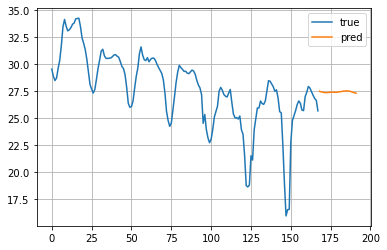

In [8]:
y_hat = nbeatsx.predict(ts_loader=train_loader)
y_plot = Y_df['y'][-168:]
y_hat_plot = y_hat['y_hat']

print("y_hat.shape", y_hat.shape)
print("y_hat_plot.shape", y_hat_plot.shape)

plt.plot(range(len(y_plot)), y_plot, label='true')
plt.plot(range(len(y_plot), len(y_plot)+len(y_hat_plot)), y_hat_plot, label='pred')
plt.legend()
plt.grid()
plt.show()